# Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sys
import forceatlas2
from fa2 import ForceAtlas2
import igraph
import cairocffi
import scipy

from matplotlib.cm import get_cmap

# Define custom functions

In [2]:
from utils import *

# Import data

## Estimated networks

In [15]:
# Parameters
date = "2020-06-30" #"2020-12-23" or "2020-09-30" or "2020-06-30" or "2020-03-16" or "2019-12-31"
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing_general(date,method,ts_type,base_path)

## Variable names

In [16]:
df = pd.read_csv('./Data/Large_network/largenet_log_ret.csv',sep=",", header=0)

print(df.head())

         Date       JPM       BAC         C       WFC        GS        MS  \
0  2012-01-03  0.000737  0.000791  0.000414  0.000180  0.000494  0.000759   
1  2012-01-04  0.006315  0.001722 -0.005664  0.004562 -0.006523 -0.008744   
2  2012-01-05  0.020672  0.082555  0.011998  0.015978 -0.001690  0.021106   
3  2012-01-06 -0.009009 -0.020817  0.001402 -0.002760 -0.012341 -0.023619   
4  2012-01-09 -0.001698  0.014458  0.018394  0.012363  0.013503  0.018692   

         BK       USB       PNC  ...  BANKBARODA.NS    D05.SI    U11.SI  \
0  0.000396  0.000389  0.000572  ...       0.046850  0.000558  0.000368   
1  0.003407 -0.000363  0.003213  ...       0.001142  0.013582  0.010873   
2  0.008226  0.014762  0.009914  ...      -0.009243 -0.005072 -0.005742   
3 -0.014563 -0.008254  0.001670  ...       0.010953  0.005072 -0.014176   
4  0.020809  0.017504  0.008146  ...      -0.009155 -0.008468 -0.016356   

     EBS.VI  DANSKE.CO   INGA.AS    DNB.OL   SBER.ME  ISCTR.IS    SBK.JO  
0  0.000361

In [17]:
var_names = list(df.columns)[1:]

print(var_names)

['JPM', 'BAC', 'C', 'WFC', 'GS', 'MS', 'BK', 'USB', 'PNC', 'COF', 'STT', 'AXP', 'FITB', 'RF', '8306.T', '8411.T', '8316.T', '8308.T', '8604.T', '8309.T', '8331.T', '8377.T', '8355.T', '8418.T', 'TD.TO', 'RY.TO', 'BNS.TO', 'BMO.TO', 'CM.TO', 'NA.TO', 'UCG.MI', 'ISP.MI', 'UNI.MI', 'MB.MI', 'NAB.AX', 'CBA.AX', 'ANZ.AX', 'WBC.AX', 'MQG.AX', '600036.SS', '600000.SS', '600016.SS', '600015.SS', 'HSBA.L', 'BARC.L', 'LLOY.L', 'STAN.L', 'SAN.MC', 'BBVA.MC', 'SAB.MC', 'SHB-A.ST', 'SEB-A.ST', 'SWED-A.ST', 'BNP.PA', 'ACA.PA', '055550.KS', '024110.KS', 'UBSG.SW', 'CSGN.SW', 'KBC.BR', 'ITUB4.SA', 'BBDC4.SA', 'DBK.DE', 'CBK.DE', 'BIRG.IR', 'SBIN.NS', 'BANKBARODA.NS', 'D05.SI', 'U11.SI', 'EBS.VI', 'DANSKE.CO', 'INGA.AS', 'DNB.OL', 'SBER.ME', 'ISCTR.IS', 'SBK.JO']


## Variable metadata (country etc)

In [18]:
var_metadata = pd.read_excel('./Data/Stock_prices/Bank_tickers.xlsx')

print(var_metadata.head())

             Bank Name Country Bank Code Reuters Ticker Yahoo Finance Ticker
0  JPMorgan Chase & Co      US    jpm.us            jpm                  JPM
1      Bank of America      US    bac.us            bac                  BAC
2            Citigroup      US      c.us              c                    C
3          Wells Fargo      US    wfc.us            wfc                  WFC
4  Goldman Sachs Group      US     gs.us             gs                   GS


In [19]:
countries = []

for var in var_names:
    try:
        country = str(var_metadata[var_metadata['Yahoo Finance Ticker']==var].Country.iloc[0])
        countries.append(country)
        
    except:
        countries.append('Other')

In [20]:
EU_countries = ['Italy','Spain','Sweden','Germany','France','Switzerland','Belgium','Denmark','Ireland',
               'Austria','Netherlands','Norway']

countries = ['EU' if country in EU_countries else country for country in countries]

In [21]:
unique_countries = list(pd.value_counts(countries).index)

In [22]:
unique_countries

['EU',
 'US',
 'Japan',
 'Canada',
 'Australia',
 'China',
 'UK',
 'Singapore',
 'India',
 'Brazil',
 'Korea',
 'Turkey',
 'South Africa',
 'Russia']

In [23]:
# Set colors
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors

name2 = "tab20b"
cmap2 = get_cmap(name2)  # type: matplotlib.colors.ListedColormap
colors2 = cmap2.colors

In [24]:
country_colors = []
collen = len(colors)

for country in countries:
    loc = unique_countries.index(country)
    if loc < collen:
        country_colors.append(colors[loc])
        
    else:
        country_colors.append(colors2[loc-collen])

# Centrality measure comparisons

In [25]:
# Parameters
varnames = var_names
centrality_type = "eigenvector" #"closeness" #"betweenness" #"katz-bonacich"
cross_holdings = False
asset_sizes = False

# Create centrality rankings
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    
# Create centrality rankings
ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

# Inspect the dataframe
display(ranking_df)

NS      SPACE     GLASSO         DY        DAG
0          WBC.AX       FITB        BAC     UCG.MI     DBK.DE
1          ANZ.AX        BAC          C      MB.MI     EBS.VI
2          NAB.AX          C        JPM     EBS.VI    UBSG.SW
3          CBA.AX     ANZ.AX     BNS.TO     8604.T   SHB-A.ST
4            FITB     BNS.TO      TD.TO    INGA.AS     CBK.DE
..            ...        ...        ...        ...        ...
71         MQG.AX     8355.T  024110.KS  DANSKE.CO  DANSKE.CO
72  BANKBARODA.NS  600000.SS  055550.KS     DNB.OL     DNB.OL
73        SBER.ME     8604.T  600000.SS    SBER.ME    SBER.ME
74       ISCTR.IS     8418.T  600015.SS   ISCTR.IS   ISCTR.IS
75         SBK.JO     8377.T  600016.SS     SBK.JO     SBK.JO

[76 rows x 5 columns]

## Rank correlation (Kendall-Tau)

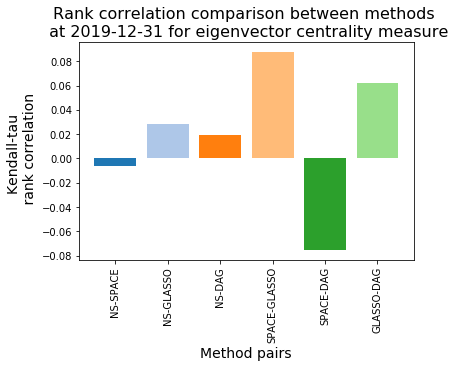

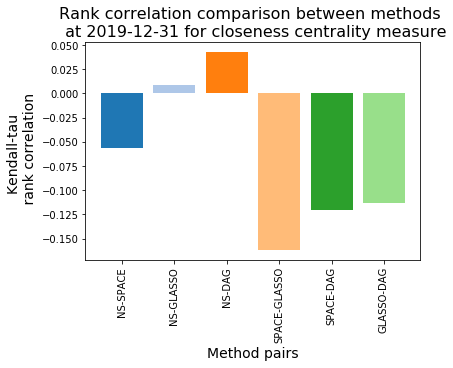

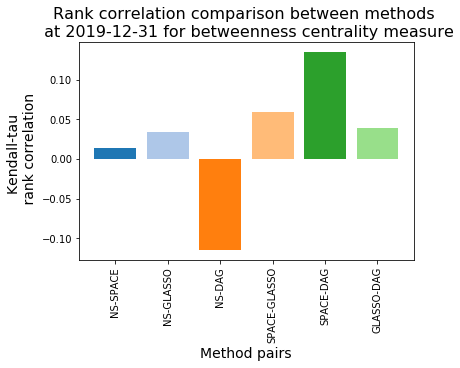

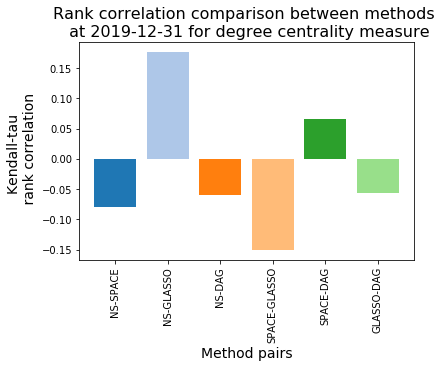

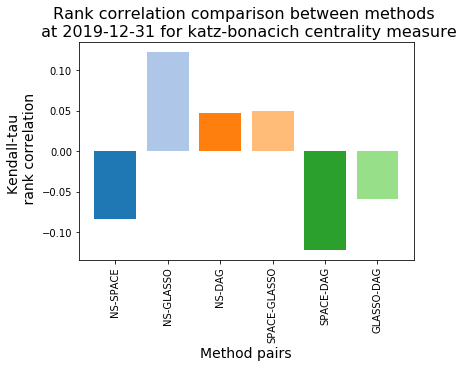

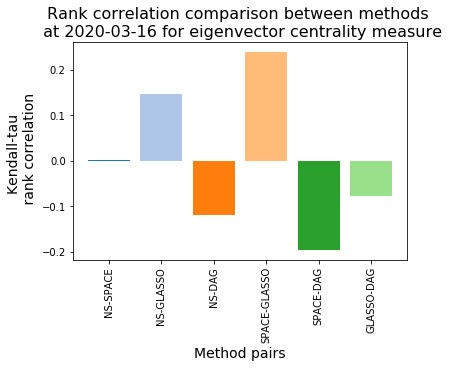

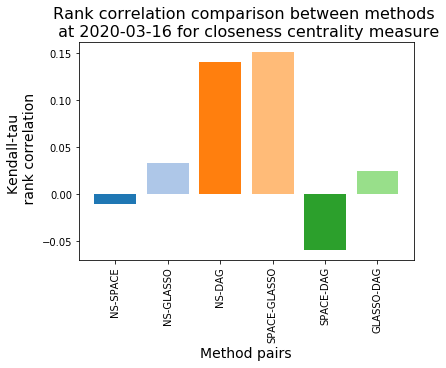

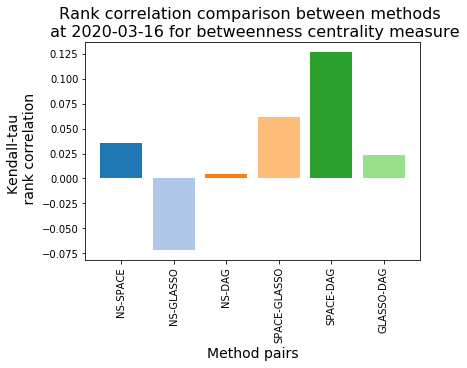

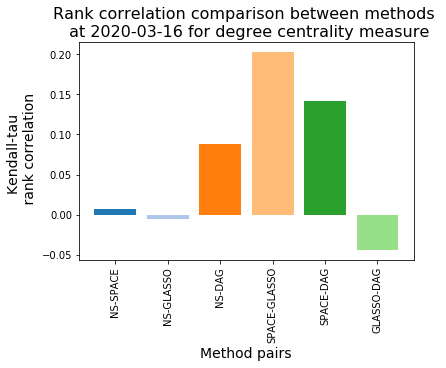

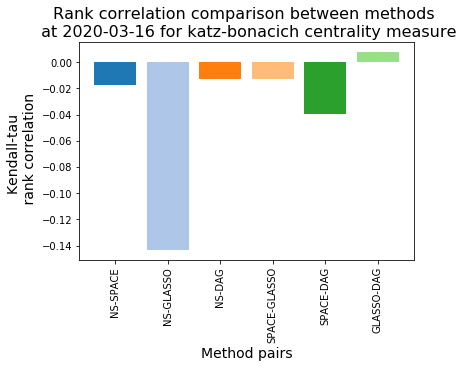

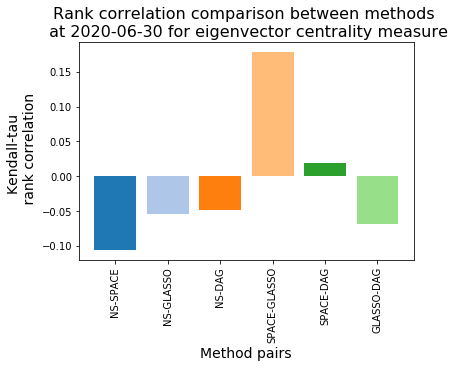

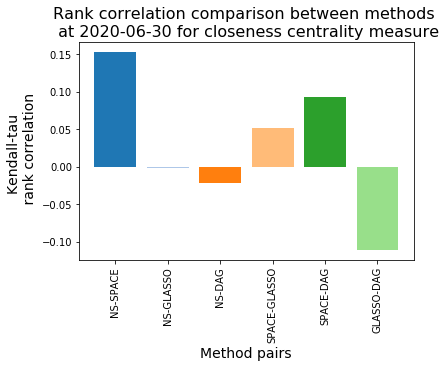

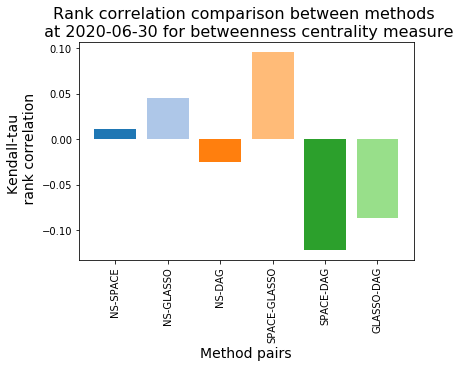

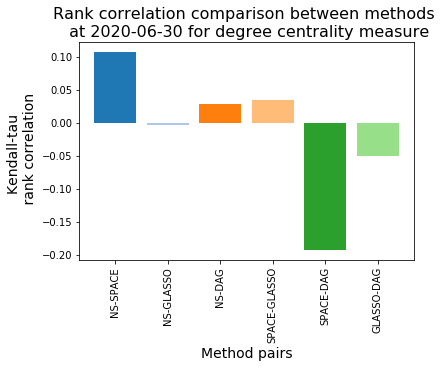

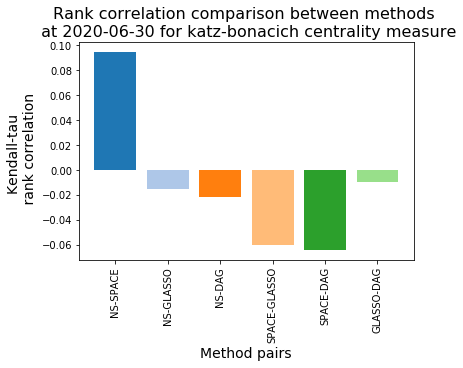

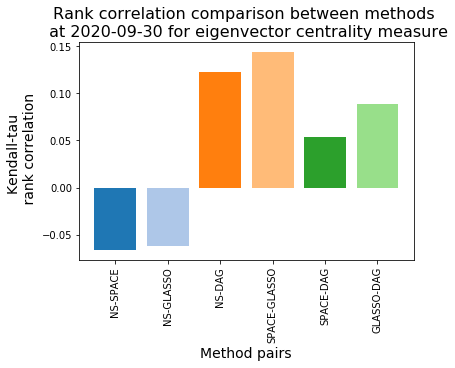

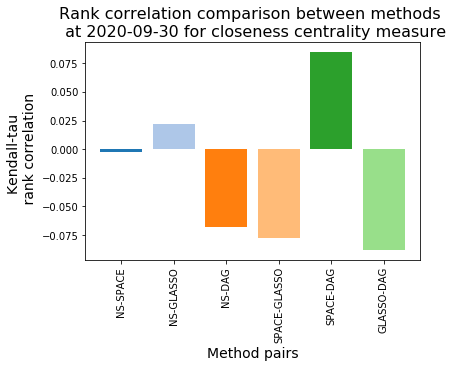

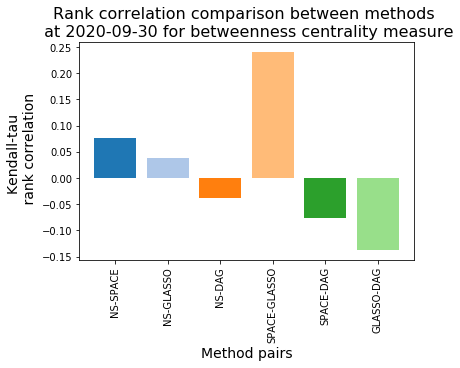

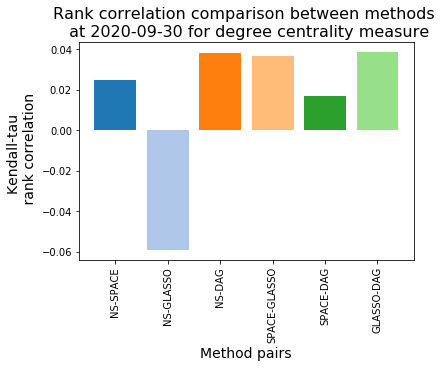

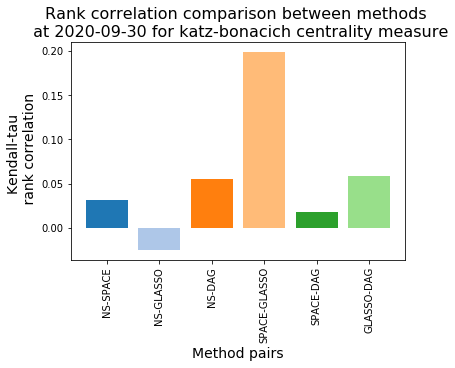

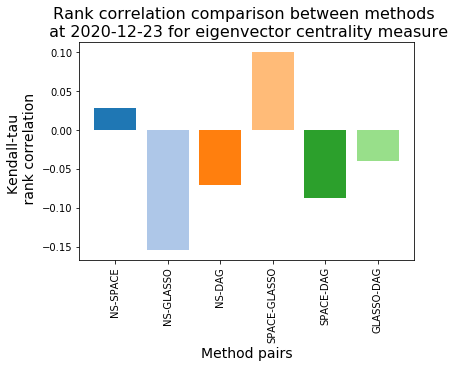

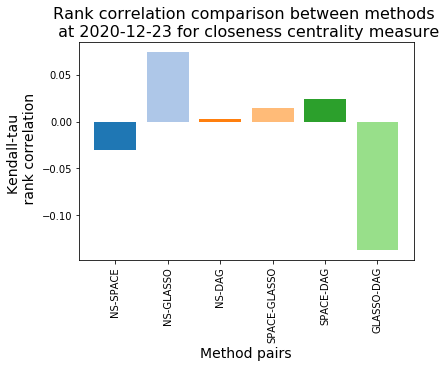

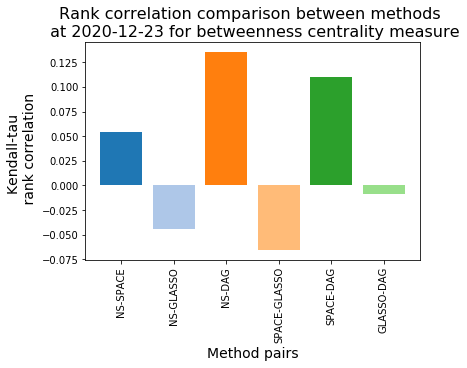

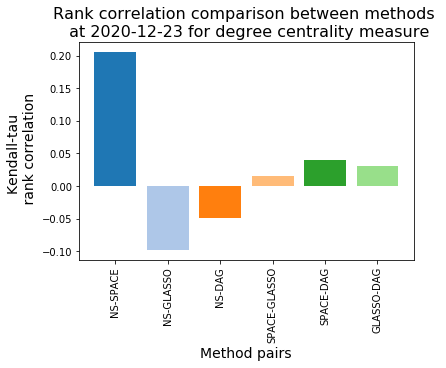

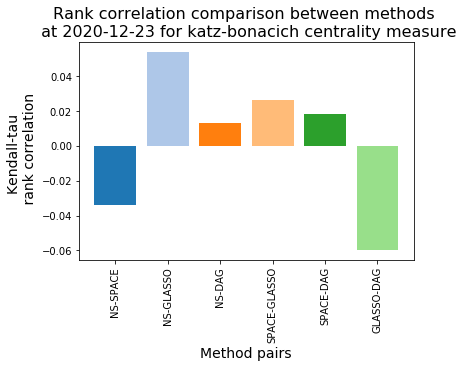

In [13]:
# Parameters
ts_type = "return"
varnames = var_names
cross_holdings = False
asset_sizes = False
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]
colors = colors

# Iterables
methods = ['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
dates = ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-23"]

# Run rank correlation comparison function
rank_correlation_comparison(dates,methods,centrality_types,ts_type,base_path,
                            cross_holdings,asset_sizes,colors,varnames)

# Ranking visualisation

## Method 'winners'

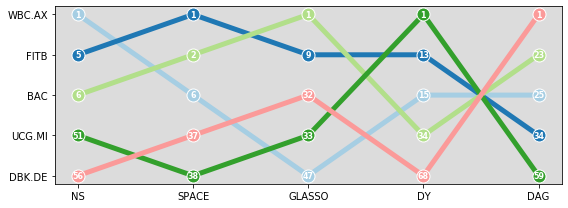

In [26]:
# Parameters
chosen_varnames = list(ranking_df.loc[0])

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Custom selection

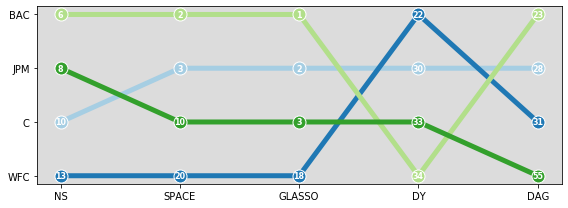

In [27]:
# Parameters
chosen_varnames = ["C","WFC","BAC","JPM"]

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Comparisons

Date: 2019-12-31
Centrality type: eigenvector
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0        BAC            BAC         BNP.PA    UBSG.SW
1        JPM            JPM            BAC     DBK.DE
2          C              C            JPM         RF
3       FITB           FITB         SAN.MC     ACA.PA
4         RF             RF        INGA.AS    CSGN.SW
..       ...            ...            ...        ...
71    8604.T      600016.SS      600015.SS  DANSKE.CO
72    EBS.VI      600015.SS      600036.SS     DNB.OL
73   SBER.ME      600036.SS        SBIN.NS    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

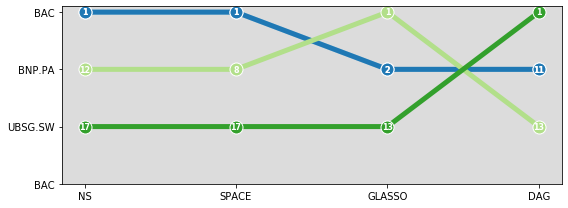

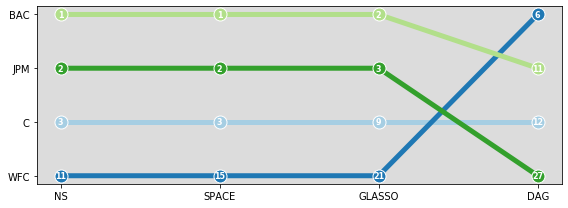

Date: 2019-12-31
Centrality type: closeness
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0       FITB         BMO.TO        CSGN.SW     DBK.DE
1        COF         BNP.PA       SHB-A.ST    UBSG.SW
2      RY.TO          MB.MI         KBC.BR     CBK.DE
3         GS         ACA.PA           FITB        WFC
4     SAB.MC         8306.T         BNS.TO     KBC.BR
..       ...            ...            ...        ...
71    8604.T         UNI.MI         8331.T  DANSKE.CO
72    EBS.VI         LLOY.L         CBA.AX     DNB.OL
73   SBER.ME      600016.SS        SBIN.NS    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

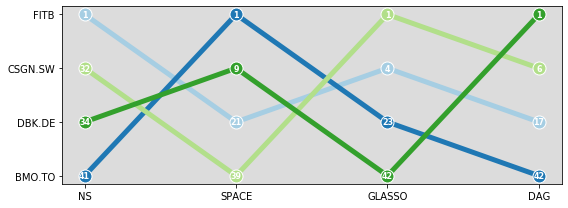

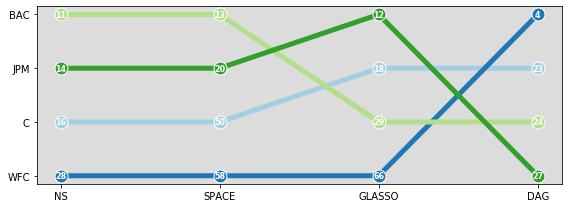

Date: 2019-12-31
Centrality type: betweenness
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO       DAG
0          SAB.MC         BNP.PA        CSGN.SW    BNP.PA
1       DANSKE.CO        UBSG.SW       SHB-A.ST       BAC
2       SWED-A.ST          MB.MI         KBC.BR   BBVA.MC
3          CBK.DE      DANSKE.CO         BNP.PA   CSGN.SW
4          DNB.OL         BMO.TO           FITB    CBK.DE
..            ...            ...            ...       ...
71  BANKBARODA.NS         KBC.BR         CBK.DE   INGA.AS
72         EBS.VI       ITUB4.SA        SBIN.NS    DNB.OL
73        SBER.ME        SBIN.NS  BANKBARODA.NS   SBER.ME
74       ISCTR.IS  BANKBARODA.NS        SBER.ME  ISCTR.IS
75         SBK.JO         U11.SI       ISCTR.IS    SBK.JO

[76 rows x 4 columns]

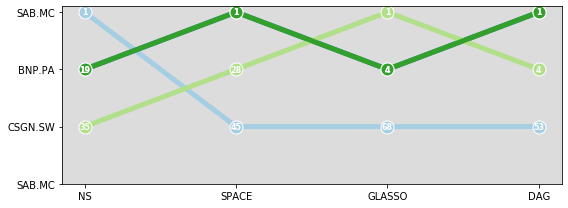

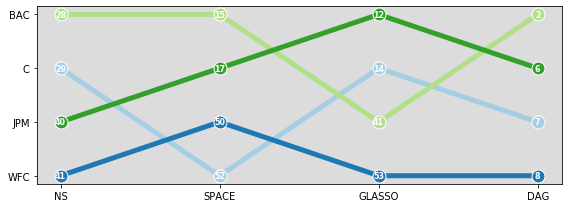

Date: 2019-12-31
Centrality type: degree
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0        BAC            BAC        UBSG.SW        JPM
1         MS         BNP.PA        CSGN.SW     BNP.PA
2       FITB        UBSG.SW         BNP.PA        BAC
3     BNP.PA        INGA.AS        INGA.AS     8306.T
4        JPM            JPM         ACA.PA     SAN.MC
..       ...            ...            ...        ...
71    8604.T         UNI.MI         CBA.AX  DANSKE.CO
72    EBS.VI      600016.SS        SBER.ME     DNB.OL
73   SBER.ME         LLOY.L        SBIN.NS    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

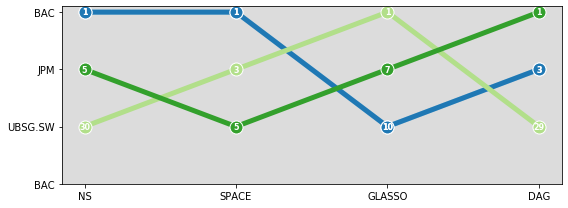

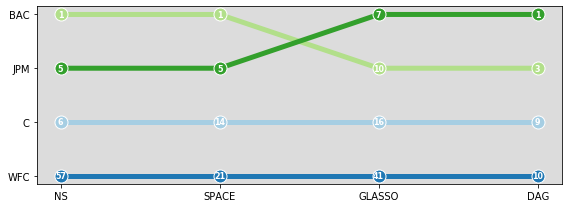

Date: 2019-12-31
Centrality type: katz-bonacich
NS
SPACE
GLASSO
DAG


NS     SPACE         GLASSO        DAG
0        BAC    8306.T         BNP.PA     ACA.PA
1     BNP.PA    BNP.PA        UBSG.SW    UBSG.SW
2     8306.T       BAC         ACA.PA         RF
3     ANZ.AX    ISP.MI         8306.T    CSGN.SW
4     ISP.MI    SAN.MC        INGA.AS     KBC.BR
..       ...       ...            ...        ...
71    8604.T    UNI.MI        SBIN.NS  DANSKE.CO
72    EBS.VI    8604.T  BANKBARODA.NS     DNB.OL
73   SBER.ME   SBER.ME         SBK.JO    SBER.ME
74  ISCTR.IS    SBK.JO        SBER.ME   ISCTR.IS
75    SBK.JO  ISCTR.IS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

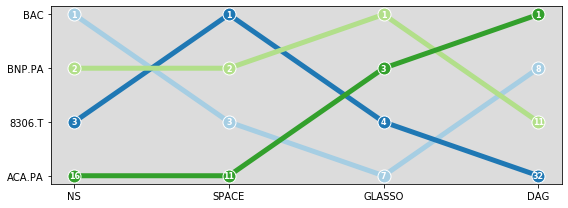

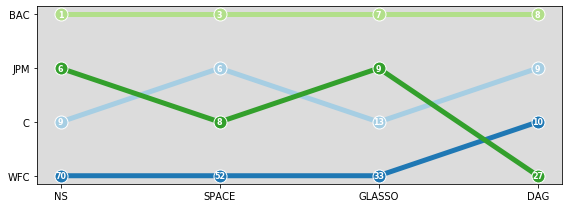

Date: 2020-03-16
Centrality type: eigenvector
NS
SPACE
GLASSO
DAG


NS      SPACE     GLASSO        DAG
0      8306.T        BAC          C     LLOY.L
1      8316.T          C     BMO.TO    CSGN.SW
2      8308.T        JPM        USB     BARC.L
3      8411.T       FITB        BAC     DBK.DE
4      8309.T     BMO.TO        JPM     SAN.MC
..        ...        ...        ...        ...
71     STAN.L  600015.SS  600000.SS  DANSKE.CO
72  055550.KS  600000.SS  600016.SS     DNB.OL
73  024110.KS  600016.SS  600015.SS    SBER.ME
74     8604.T  024110.KS  024110.KS   ISCTR.IS
75   ISCTR.IS  055550.KS  055550.KS     SBK.JO

[76 rows x 4 columns]

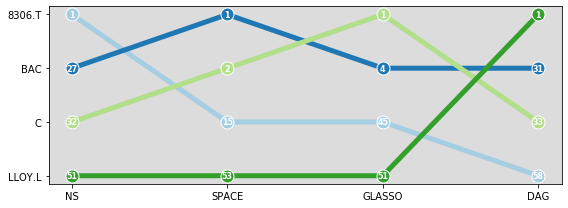

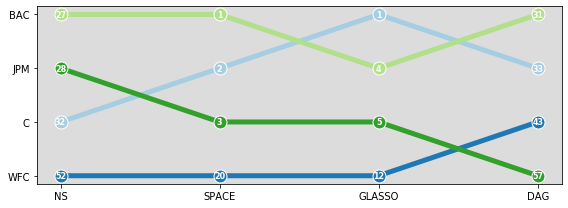

Date: 2020-03-16
Centrality type: closeness
NS
SPACE
GLASSO
DAG


NS      SPACE     GLASSO        DAG
0      KBC.BR     BMO.TO     ANZ.AX     LLOY.L
1      BARC.L     WBC.AX    CSGN.SW     DBK.DE
2    SHB-A.ST     ACA.PA         RF     BARC.L
3      ISP.MI         MS     BMO.TO     EBS.VI
4      UNI.MI     ISP.MI     STAN.L     CBK.DE
..        ...        ...        ...        ...
71    SBIN.NS     DBK.DE  600016.SS  DANSKE.CO
72  055550.KS        STT  600015.SS     DNB.OL
73  024110.KS      RY.TO    INGA.AS    SBER.ME
74     8604.T        PNC  600000.SS   ISCTR.IS
75   ISCTR.IS  600016.SS     8308.T     SBK.JO

[76 rows x 4 columns]

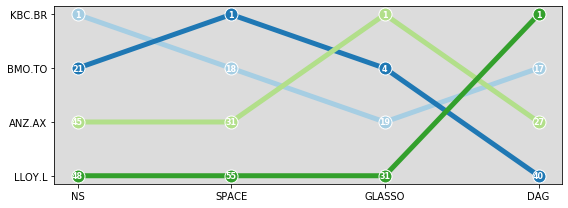

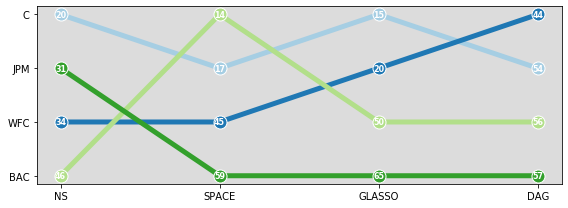

Date: 2020-03-16
Centrality type: betweenness
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO       DAG
0   SHB-A.ST         BMO.TO  DANSKE.CO    UCG.MI
1     KBC.BR         U11.SI     BMO.TO    ISP.MI
2     BARC.L         ACA.PA     UNI.MI    BNS.TO
3     MQG.AX         WBC.AX   ISCTR.IS   BBVA.MC
4          C             MS     BNP.PA    SAN.MC
..       ...            ...        ...       ...
71   SBIN.NS         DBK.DE  600016.SS   INGA.AS
72    D05.SI        BIRG.IR    BBVA.MC    DNB.OL
73    U11.SI        SBIN.NS  024110.KS   SBER.ME
74  ISCTR.IS  BANKBARODA.NS    BIRG.IR  ISCTR.IS
75    SBK.JO         EBS.VI    SBIN.NS    SBK.JO

[76 rows x 4 columns]

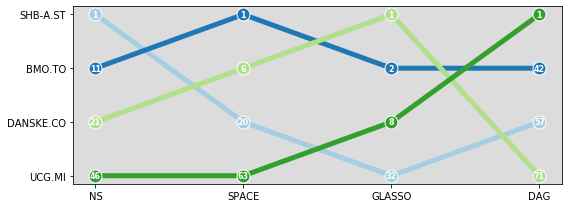

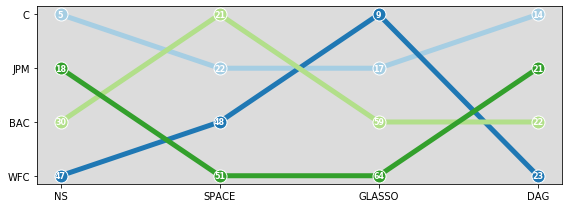

Date: 2020-03-16
Centrality type: degree
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO        DAG
0          C         BMO.TO     ACA.PA        JPM
1     BMO.TO              C     BMO.TO     UCG.MI
2     ISP.MI         ACA.PA        WFC     8306.T
3     ACA.PA        CSGN.SW    CSGN.SW     ISP.MI
4    INGA.AS         ISP.MI     EBS.VI     NAB.AX
..       ...            ...        ...        ...
71  ITUB4.SA      024110.KS  600000.SS  DANSKE.CO
72   SBIN.NS  BANKBARODA.NS  600016.SS     DNB.OL
73    SBK.JO      055550.KS  600015.SS    SBER.ME
74    8604.T       ITUB4.SA  024110.KS   ISCTR.IS
75  ISCTR.IS        SBIN.NS  055550.KS     SBK.JO

[76 rows x 4 columns]

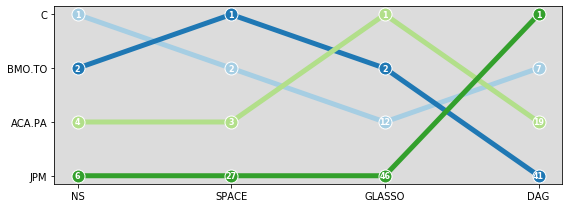

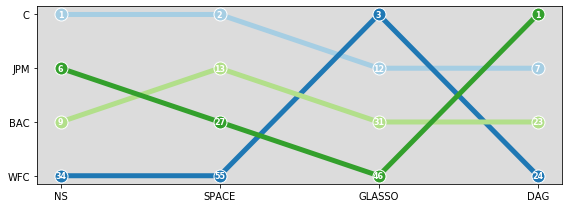

Date: 2020-03-16
Centrality type: katz-bonacich
NS
SPACE
GLASSO
DAG


NS     SPACE     GLASSO        DAG
0     ISP.MI    8306.T    INGA.AS    CSGN.SW
1     8306.T    ISP.MI    CSGN.SW     WBC.AX
2        BAC    8316.T     ACA.PA     SAN.MC
3     ANZ.AX         C    UBSG.SW      CM.TO
4       FITB      FITB     ISP.MI     NAB.AX
..       ...       ...        ...        ...
71    SAB.MC    DNB.OL  024110.KS  DANSKE.CO
72    DNB.OL   SBER.ME    SBER.ME     DNB.OL
73    SBK.JO    8604.T  055550.KS    SBER.ME
74    8604.T    SBK.JO     SBK.JO   ISCTR.IS
75  ISCTR.IS  ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 4 columns]

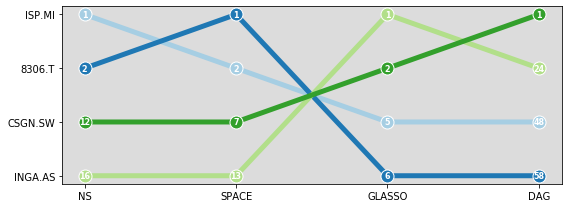

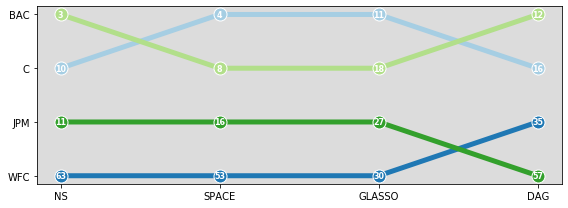

Date: 2020-06-30
Centrality type: eigenvector
NS
SPACE
GLASSO
DAG


NS      SPACE     GLASSO        DAG
0          WBC.AX       FITB        BAC     DBK.DE
1          ANZ.AX        BAC          C     EBS.VI
2          NAB.AX          C        JPM    UBSG.SW
3          CBA.AX     ANZ.AX     BNS.TO   SHB-A.ST
4            FITB     BNS.TO      TD.TO     CBK.DE
..            ...        ...        ...        ...
71         MQG.AX     8355.T  024110.KS  DANSKE.CO
72  BANKBARODA.NS  600000.SS  055550.KS     DNB.OL
73        SBER.ME     8604.T  600000.SS    SBER.ME
74       ISCTR.IS     8418.T  600015.SS   ISCTR.IS
75         SBK.JO     8377.T  600016.SS     SBK.JO

[76 rows x 4 columns]

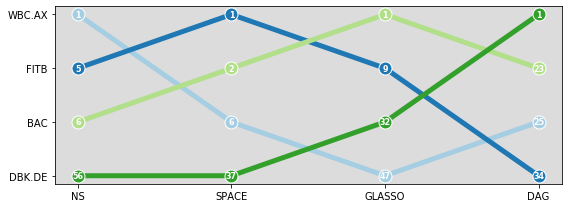

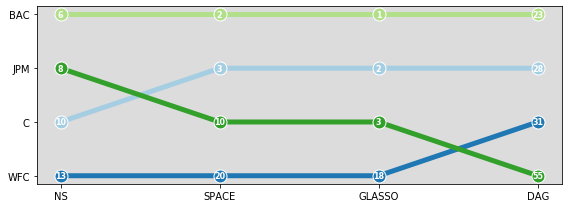

Date: 2020-06-30
Centrality type: closeness
NS
SPACE
GLASSO
DAG


NS      SPACE     GLASSO        DAG
0      CBK.DE  600000.SS     SAB.MC     DBK.DE
1     BIRG.IR     BMO.TO     BMO.TO   SHB-A.ST
2      ACA.PA     BARC.L     DBK.DE     CBK.DE
3     INGA.AS     UCG.MI        AXP    UBSG.SW
4      DBK.DE        BAC      MB.MI     EBS.VI
..        ...        ...        ...        ...
71     NAB.AX     8309.T     8309.T  DANSKE.CO
72     ANZ.AX     8316.T     8331.T     DNB.OL
73     CBA.AX     UNI.MI  055550.KS    SBER.ME
74     WBC.AX     CBA.AX     8377.T   ISCTR.IS
75  055550.KS  600016.SS     8418.T     SBK.JO

[76 rows x 4 columns]

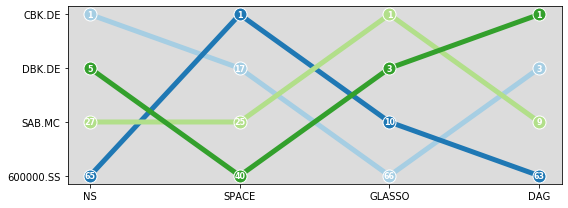

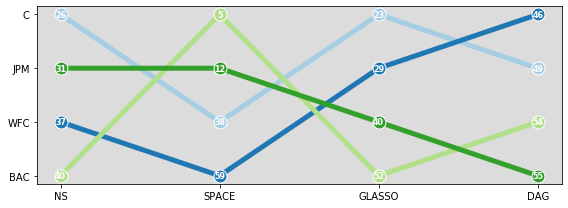

Date: 2020-06-30
Centrality type: betweenness
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO        DAG
0          CBK.DE      600000.SS     SAB.MC    BBVA.MC
1         INGA.AS         BMO.TO     BMO.TO     BARC.L
2          ACA.PA            AXP     LLOY.L     SAN.MC
3             AXP            BAC     BNP.PA     ACA.PA
4       DANSKE.CO         BARC.L        AXP    CSGN.SW
..            ...            ...        ...        ...
71  BANKBARODA.NS        SBIN.NS     CBK.DE  DANSKE.CO
72         D05.SI  BANKBARODA.NS    SBIN.NS     DNB.OL
73         EBS.VI         U11.SI     D05.SI    SBER.ME
74       ISCTR.IS         EBS.VI  DANSKE.CO   ISCTR.IS
75         SBK.JO      DANSKE.CO    INGA.AS     SBK.JO

[76 rows x 4 columns]

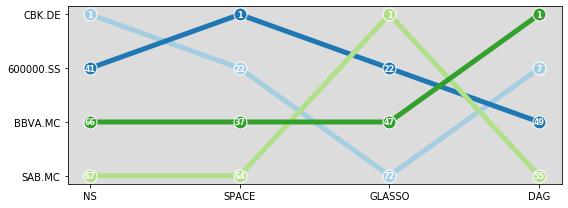

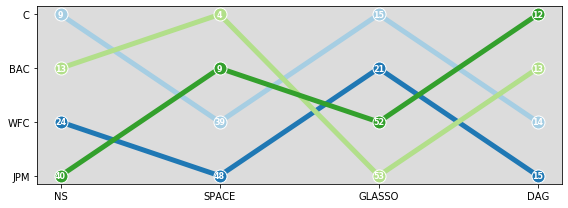

Date: 2020-06-30
Centrality type: degree
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO        DAG
0          ACA.PA            BAC     BNP.PA        JPM
1         INGA.AS         BMO.TO     ACA.PA      TD.TO
2             BAC       SEB-A.ST     BARC.L     8306.T
3               C         ACA.PA    CSGN.SW     NAB.AX
4             AXP        CSGN.SW      NA.TO     SAN.MC
..            ...            ...        ...        ...
71       ITUB4.SA      055550.KS     8418.T  DANSKE.CO
72  BANKBARODA.NS      024110.KS  600015.SS     DNB.OL
73         D05.SI       BBDC4.SA  024110.KS    SBER.ME
74       ISCTR.IS  BANKBARODA.NS  055550.KS   ISCTR.IS
75         SBK.JO       ITUB4.SA  600016.SS     SBK.JO

[76 rows x 4 columns]

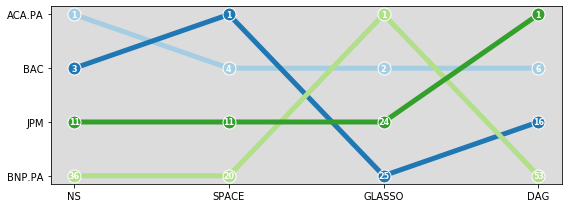

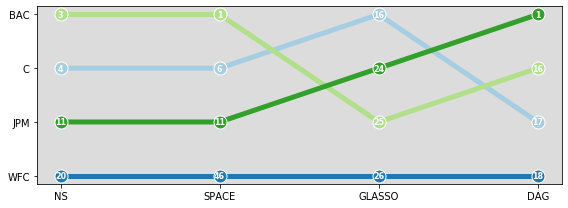

Date: 2020-06-30
Centrality type: katz-bonacich
NS
SPACE
GLASSO
DAG


NS     SPACE         GLASSO        DAG
0    CSGN.SW   CSGN.SW        CSGN.SW     BNS.TO
1     ACA.PA    8306.T         ACA.PA      RY.TO
2       FITB    ANZ.AX        BBVA.MC      CM.TO
3        BAC    ACA.PA         BMO.TO     SAN.MC
4     8306.T    BNS.TO         CBK.DE     BMO.TO
..       ...       ...            ...        ...
71   SBER.ME    8604.T         UNI.MI  DANSKE.CO
72    MQG.AX    CBA.AX       ITUB4.SA     DNB.OL
73  ISCTR.IS    SBK.JO  BANKBARODA.NS    SBER.ME
74    SBK.JO  ISCTR.IS       ISCTR.IS   ISCTR.IS
75    8604.T   SBER.ME        SBER.ME     SBK.JO

[76 rows x 4 columns]

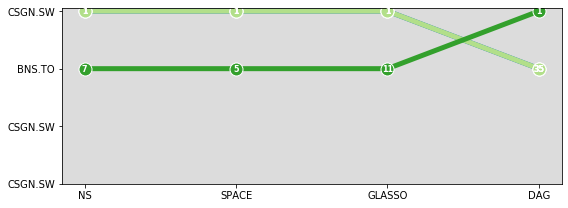

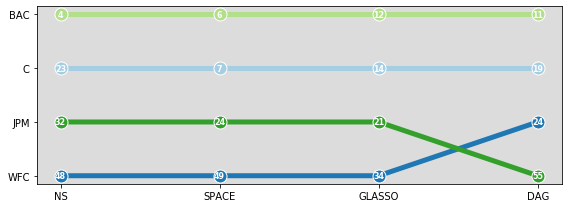

Date: 2020-09-30
Centrality type: eigenvector
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO       DAG
0     WBC.AX         WBC.AX        BAC       PNC
1     ANZ.AX         ANZ.AX        JPM      FITB
2     NAB.AX           FITB          C  BBDC4.SA
3     CBA.AX            BAC      TD.TO       STT
4       FITB         NAB.AX     BNS.TO    CBK.DE
..       ...            ...        ...       ...
71    D05.SI         8418.T  055550.KS    BNS.TO
72    8604.T        SBER.ME  600036.SS     RY.TO
73    MQG.AX         8604.T  600000.SS       COF
74  ISCTR.IS         8377.T  600016.SS     TD.TO
75    SBK.JO  BANKBARODA.NS  600015.SS       JPM

[76 rows x 4 columns]

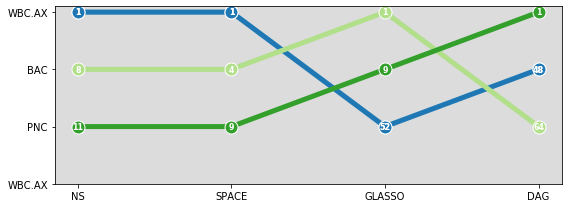

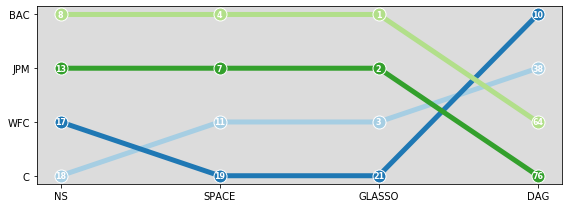

Date: 2020-09-30
Centrality type: closeness
NS
SPACE
GLASSO
DAG


NS      SPACE     GLASSO     DAG
0      8331.T     8604.T     CBK.DE  EBS.VI
1      8308.T        AXP     DNB.OL  8316.T
2     CSGN.SW   SEB-A.ST   SEB-A.ST     PNC
3      LLOY.L     ISP.MI     STAN.L      BK
4      ACA.PA      TD.TO    BBVA.MC   NA.TO
..        ...        ...        ...     ...
71  024110.KS         BK      TD.TO   RY.TO
72     8604.T     8316.T      MB.MI  BNS.TO
73     MQG.AX        USB     8418.T   TD.TO
74   ISCTR.IS  600016.SS  600015.SS     COF
75     SBK.JO   ITUB4.SA  600016.SS     JPM

[76 rows x 4 columns]

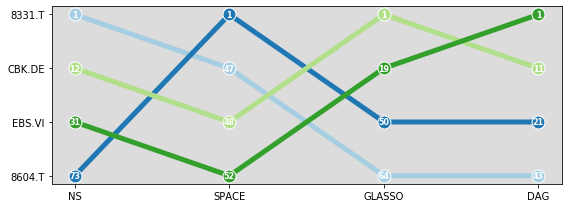

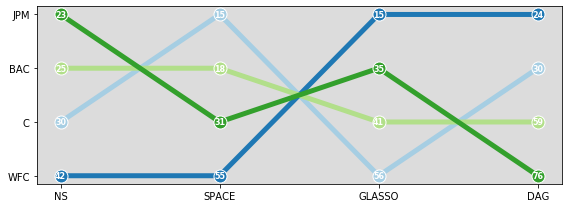

Date: 2020-09-30
Centrality type: betweenness
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO        DAG
0         GS         8604.T     DNB.OL     MQG.AX
1    CSGN.SW          TD.TO     CBK.DE     8308.T
2        AXP            AXP    BBVA.MC    INGA.AS
3      RY.TO       SEB-A.ST   SEB-A.ST  600000.SS
4        JPM         ISP.MI  SWED-A.ST     KBC.BR
..       ...            ...        ...        ...
71    EBS.VI        CSGN.SW     SAB.MC     8604.T
72    DNB.OL         KBC.BR  055550.KS      NA.TO
73   SBER.ME       ITUB4.SA    SBIN.NS      MB.MI
74  ISCTR.IS  BANKBARODA.NS  DANSKE.CO     STAN.L
75    SBK.JO        SBER.ME    SBER.ME     EBS.VI

[76 rows x 4 columns]

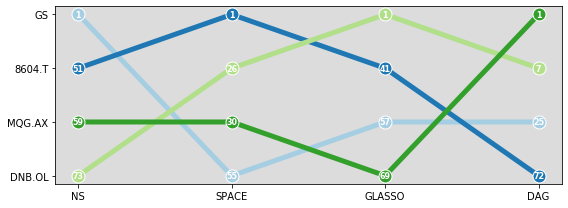

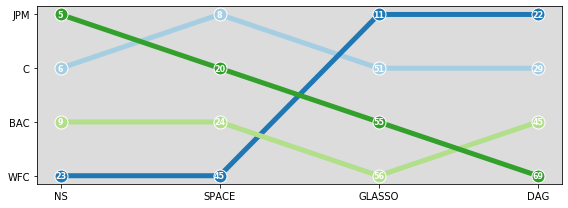

Date: 2020-09-30
Centrality type: degree
NS
SPACE
GLASSO
DAG


NS          SPACE     GLASSO            DAG
0     ACA.PA       SEB-A.ST     BNP.PA            JPM
1        BAC         BARC.L     ACA.PA         UCG.MI
2    CSGN.SW        INGA.AS    CSGN.SW         UNI.MI
3         MS          TD.TO     BARC.L         8306.T
4          C            AXP      CM.TO         8377.T
..       ...            ...        ...            ...
71   SBER.ME      600015.SS    SBER.ME        UBSG.SW
72    8604.T      055550.KS     8418.T  BANKBARODA.NS
73    MQG.AX       BBDC4.SA  055550.KS            BAC
74  ISCTR.IS  BANKBARODA.NS  600016.SS         8418.T
75    SBK.JO       ITUB4.SA  600015.SS         SAB.MC

[76 rows x 4 columns]

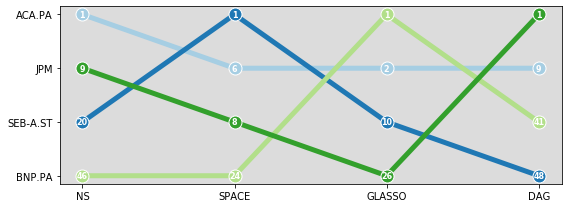

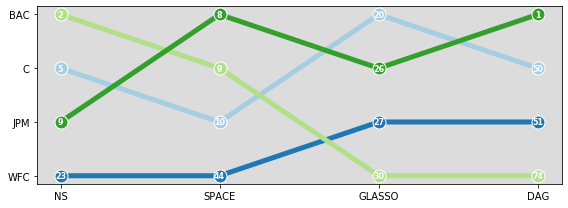

Date: 2020-09-30
Centrality type: katz-bonacich
NS
SPACE
GLASSO
DAG


NS     SPACE         GLASSO       DAG
0      ACA.PA    8306.T         ACA.PA    EBS.VI
1        FITB   CSGN.SW        CSGN.SW    8411.T
2         BAC    ANZ.AX         BMO.TO   SBIN.NS
3     CSGN.SW    ACA.PA         BNP.PA    8604.T
4   600016.SS    SAN.MC         BARC.L    BNP.PA
..        ...       ...            ...       ...
71    SBER.ME    MQG.AX       ITUB4.SA  ISCTR.IS
72     8604.T    8604.T         SBK.JO    UCG.MI
73     MQG.AX    SBK.JO  BANKBARODA.NS   SBER.ME
74   ISCTR.IS   SBER.ME       ISCTR.IS    SBK.JO
75     SBK.JO  ISCTR.IS        SBER.ME       JPM

[76 rows x 4 columns]

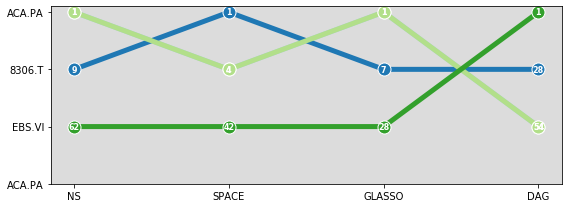

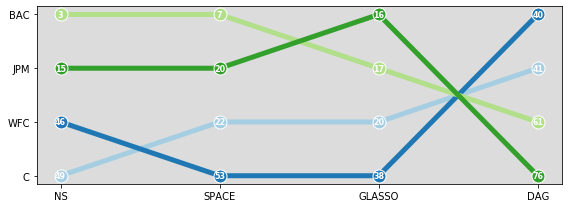

Date: 2020-12-23
Centrality type: eigenvector
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0     WBC.AX           FITB         BNP.PA    BBVA.MC
1     ANZ.AX             RF            JPM     EBS.VI
2     NAB.AX            JPM         ACA.PA     LLOY.L
3     CBA.AX            BAC         SAN.MC    UBSG.SW
4         RF            USB            BAC     8355.T
..       ...            ...            ...        ...
71    D05.SI  BANKBARODA.NS      600036.SS  DANSKE.CO
72    U11.SI      600000.SS  BANKBARODA.NS     DNB.OL
73   SBER.ME      600016.SS      600016.SS    SBER.ME
74  ISCTR.IS      600036.SS      600000.SS   ISCTR.IS
75    SBK.JO      600015.SS      600015.SS     SBK.JO

[76 rows x 4 columns]

Date: 2020-12-23
Centrality type: closeness
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0     EBS.VI          CM.TO       ITUB4.SA     DBK.DE
1    INGA.AS         BNS.TO        INGA.AS     8377.T
2     LLOY.L            AXP         DBK.DE     8355.T
3     KBC.BR         EBS.VI         8316.T    UBSG.SW
4     SAB.MC        SBIN.NS          CM.TO     LLOY.L
..       ...            ...            ...        ...
71  ITUB4.SA         NAB.AX      600000.SS  DANSKE.CO
72  BBDC4.SA      600016.SS         8418.T     DNB.OL
73   SBER.ME      600015.SS         8355.T    SBER.ME
74  ISCTR.IS  BANKBARODA.NS      600015.SS   ISCTR.IS
75    SBK.JO       ITUB4.SA  BANKBARODA.NS     SBK.JO

[76 rows x 4 columns]

Date: 2020-12-23
Centrality type: betweenness
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0      EBS.VI        CSGN.SW       ITUB4.SA     BNP.PA
1    SHB-A.ST        INGA.AS         DBK.DE     8331.T
2      KBC.BR         BNS.TO          CM.TO     SAN.MC
3       TD.TO          CM.TO        INGA.AS     8308.T
4      ISP.MI      024110.KS       BBDC4.SA  600000.SS
..        ...            ...            ...        ...
71     U11.SI         BNP.PA      600015.SS    INGA.AS
72  DANSKE.CO      055550.KS        UBSG.SW     DNB.OL
73    SBER.ME       ITUB4.SA  BANKBARODA.NS    SBER.ME
74   ISCTR.IS        BIRG.IR        SBER.ME   ISCTR.IS
75     SBK.JO  BANKBARODA.NS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

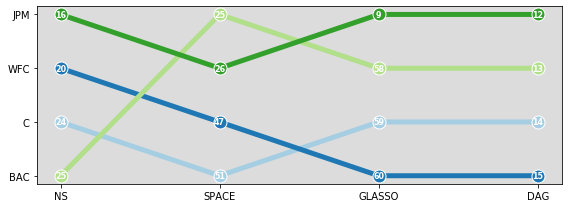

Date: 2020-12-23
Centrality type: degree
NS
SPACE
GLASSO
DAG


NS          SPACE         GLASSO        DAG
0     EBS.VI         EBS.VI         BNP.PA        JPM
1        JPM            JPM         EBS.VI     BNP.PA
2        USB         BNP.PA        INGA.AS     8306.T
3     8308.T        CSGN.SW        CSGN.SW     8331.T
4     8331.T        INGA.AS         KBC.BR      TD.TO
..       ...            ...            ...        ...
71    D05.SI      600016.SS       ISCTR.IS  DANSKE.CO
72    U11.SI      600015.SS      600000.SS     DNB.OL
73   SBER.ME      055550.KS      600016.SS    SBER.ME
74  ISCTR.IS       ITUB4.SA      600015.SS   ISCTR.IS
75    SBK.JO  BANKBARODA.NS  BANKBARODA.NS     SBK.JO

[76 rows x 4 columns]

Date: 2020-12-23
Centrality type: katz-bonacich
NS
SPACE
GLASSO
DAG


NS      SPACE         GLASSO        DAG
0      BNP.PA     BNP.PA         BNP.PA     ACA.PA
1      8316.T        JPM        CSGN.SW     SAN.MC
2   600000.SS     ANZ.AX            JPM    UBSG.SW
3         JPM  600000.SS         ACA.PA    INGA.AS
4        FITB     SAN.MC         ISP.MI    BBVA.MC
..        ...        ...            ...        ...
71     8604.T      MB.MI         MQG.AX  DANSKE.CO
72     MQG.AX     MQG.AX        SBER.ME     DNB.OL
73    SBER.ME     SBK.JO         SBK.JO    SBER.ME
74   ISCTR.IS    SBER.ME  BANKBARODA.NS   ISCTR.IS
75     SBK.JO   ISCTR.IS       ISCTR.IS     SBK.JO

[76 rows x 4 columns]

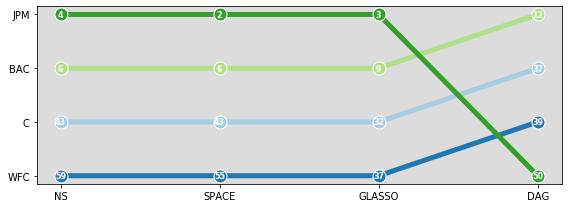

In [17]:
# Parameters
varnames = var_names
cross_holdings = False
asset_sizes = False

ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]



# Iterables
methods = ['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
dates = ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-23"]

for date in dates:
    for centrality_type in centrality_types:

        # Create dictionary to store the outputs
        networks = {}

        for method in methods:

            networks[method] = network_preprocessing_general(date,method,ts_type,base_path)



        print("Date: {}".format(date))
        print("Centrality type: {}".format(centrality_type))


        # Create centrality rankings
        if cross_holdings:
            CH_network = CH_network
        else:
            CH_network = None

        if asset_sizes:
            varnames_sorted_by_asset = varnames_sorted_by_asset
        else:
            varnames_sorted_by_asset = None

        # Create centrality rankings
        ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

        # Inspect the dataframe
        display(ranking_df)

        # Parameters
        current_winners = list(ranking_df.loc[0])

        # Run the visualisation function
        rank_viz_general(current_winners,ranking_df,centrality_type,date,ts_type,data_type)


        # Run the visualisation function
        rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

# Robustness/persistence checks

In [15]:
# Parameters
dates = ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-23"]
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
# DAG 2020-09-30 issue! --> Solved!

In [26]:
# Check robustness results
robustness_results = {}

for method in methods:
    
    res = []
    
    for i in range(1,len(dates)):
        
        current_dates = dates[i-1:i+1]
        
        frob_norm = general_robustness_check(current_dates,method,ts_type,base_path)
        res.append(frob_norm)
        
    robustness_results[method] = res

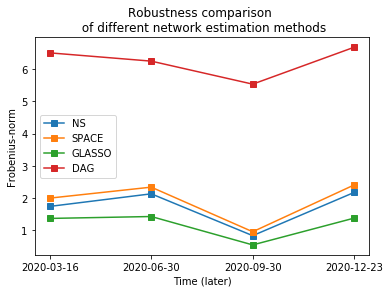

In [27]:
for key, val in robustness_results.items():
    
    plt.plot(val,marker="s",label=key)
    
plt.legend(loc = 'center left')
plt.title("Robustness comparison \n of different network estimation methods")
#plt.yscale('log')
plt.xlabel("Time (later)")
plt.ylabel("Frobenius-norm")
plt.xticks(np.arange(len(dates)-1),dates[1:])
plt.savefig('./Figures/Large_network/persistence_robustness.pdf',dpi=120)
plt.show()

# Visualise network

## Single examples

Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

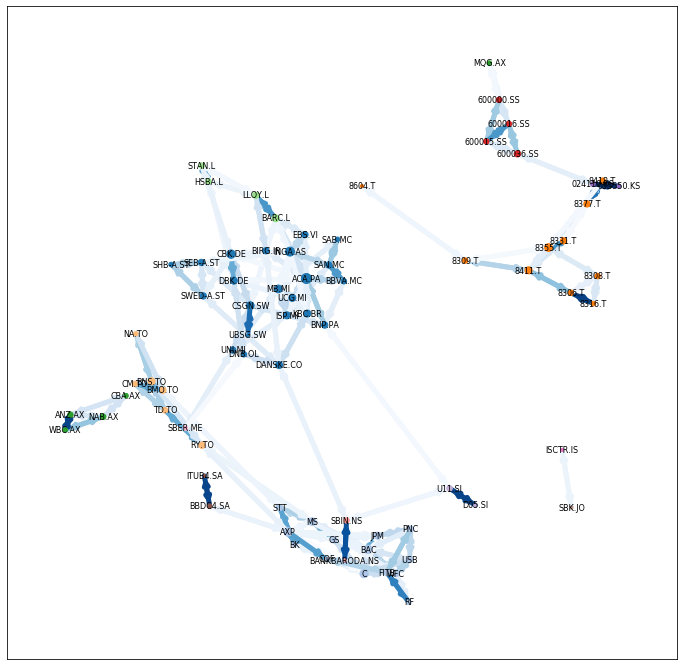

Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

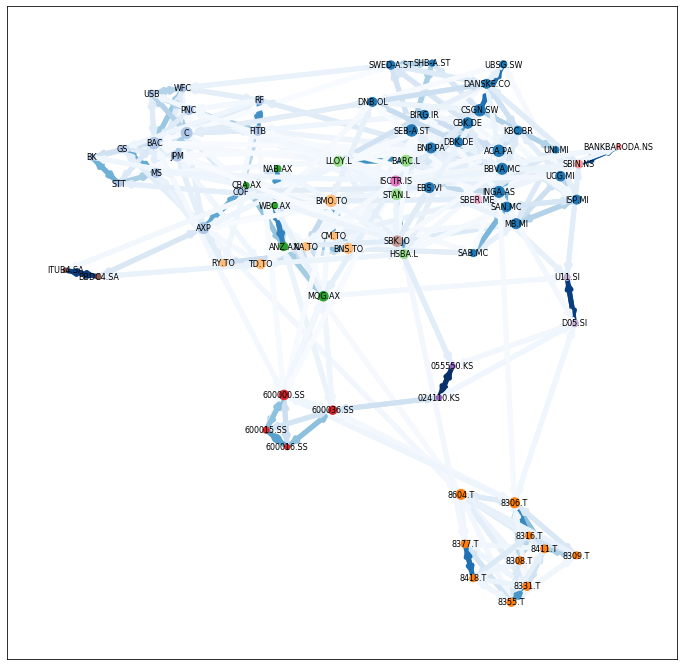

Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

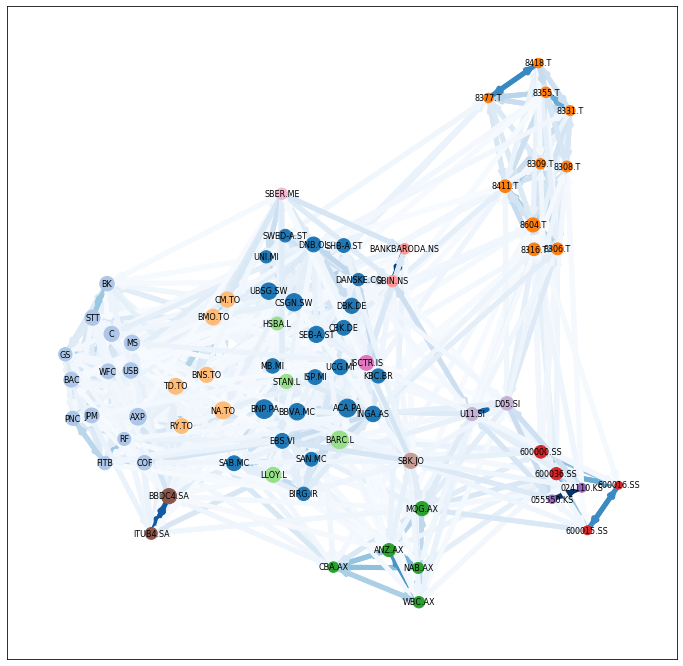

Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

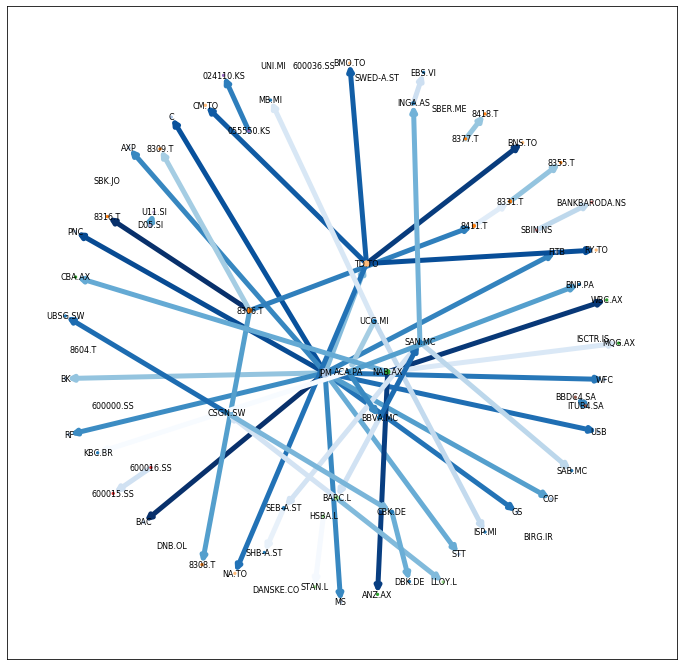

In [44]:
# Parameters
date = "2020-06-30"
ts_type = "return"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

for method in methods:
    
    network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

## Combinations

Date: 2019-12-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

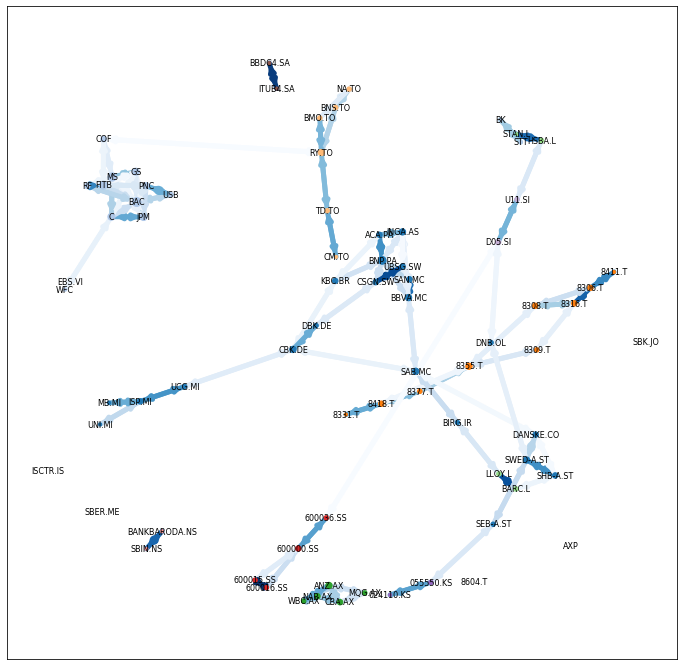

Date: 2019-12-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

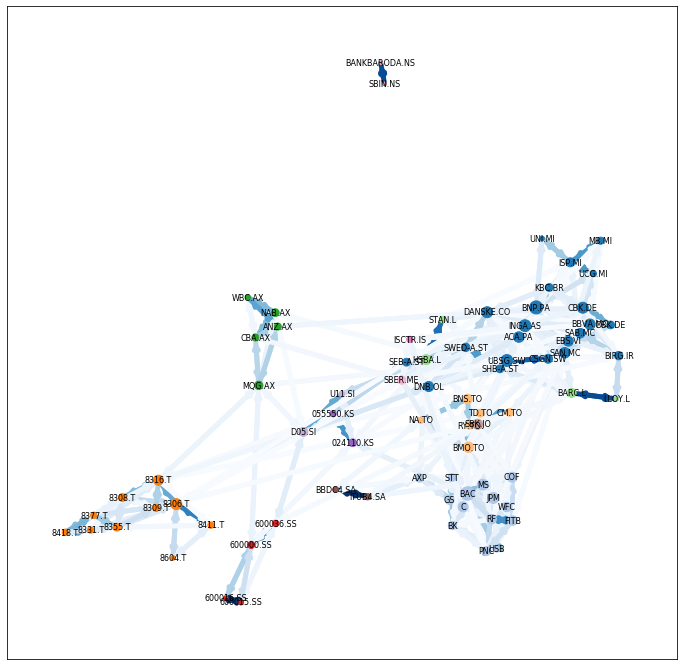

Date: 2019-12-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

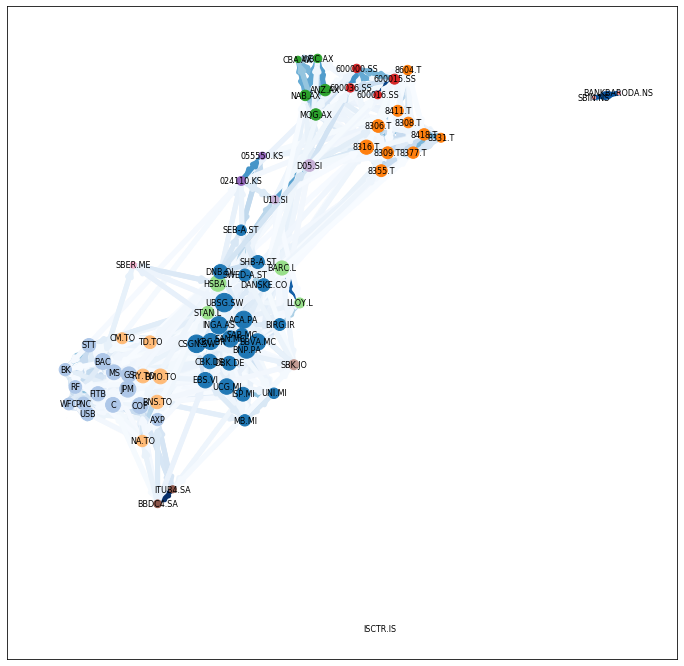

Date: 2019-12-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

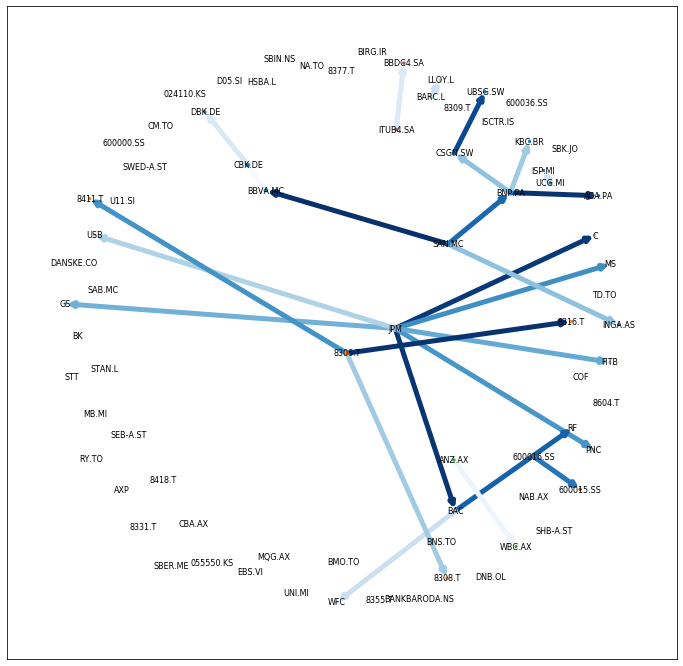

Date: 2020-03-16
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

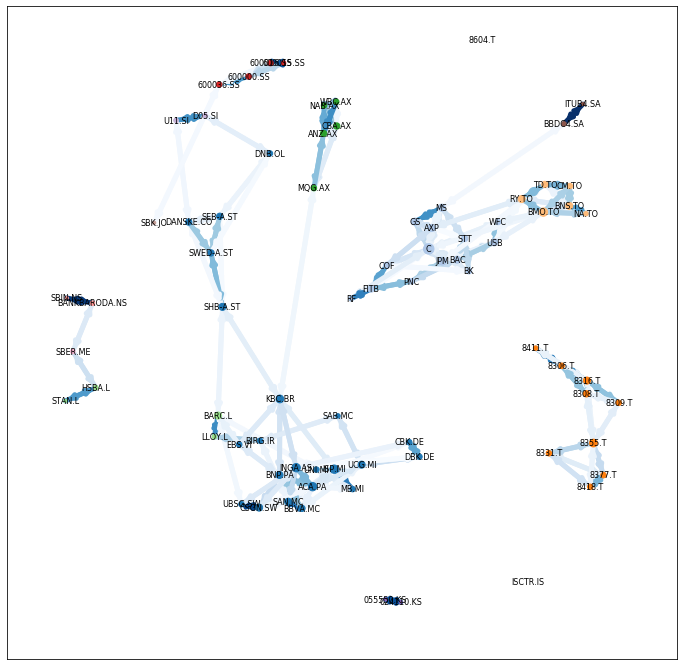

Date: 2020-03-16
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

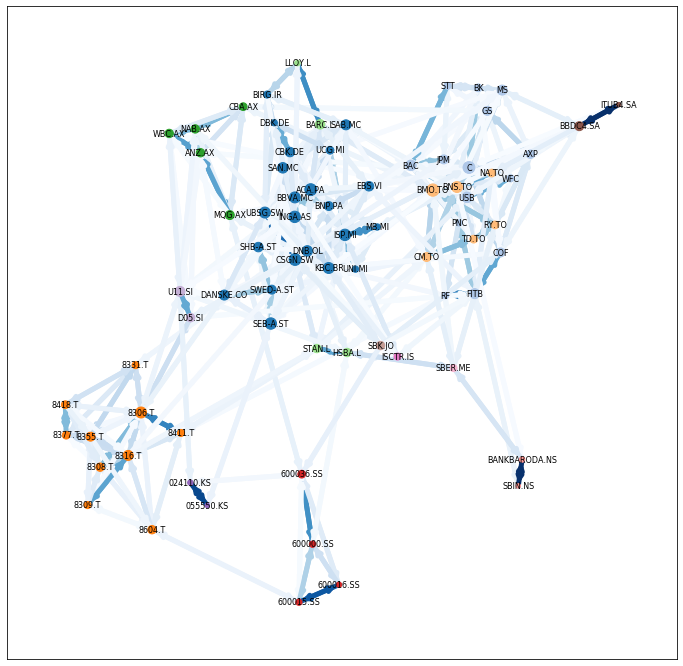

Date: 2020-03-16
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-03-16
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-06-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

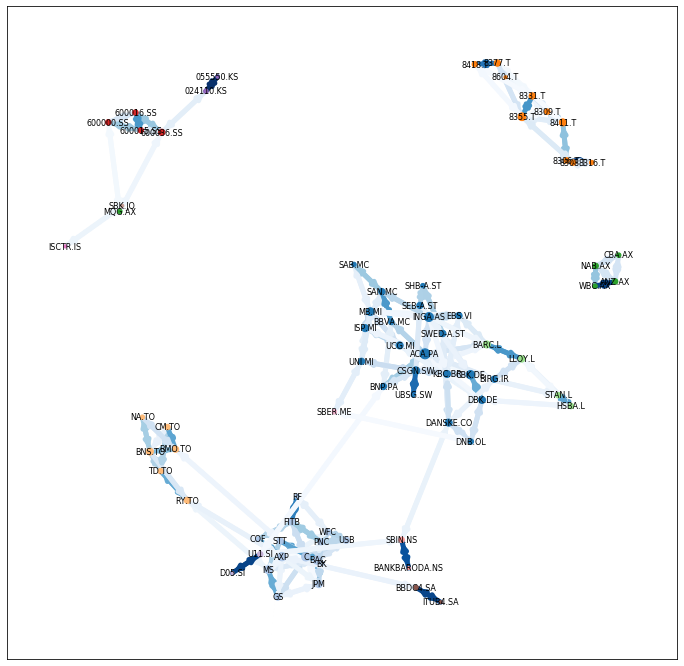

Date: 2020-06-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

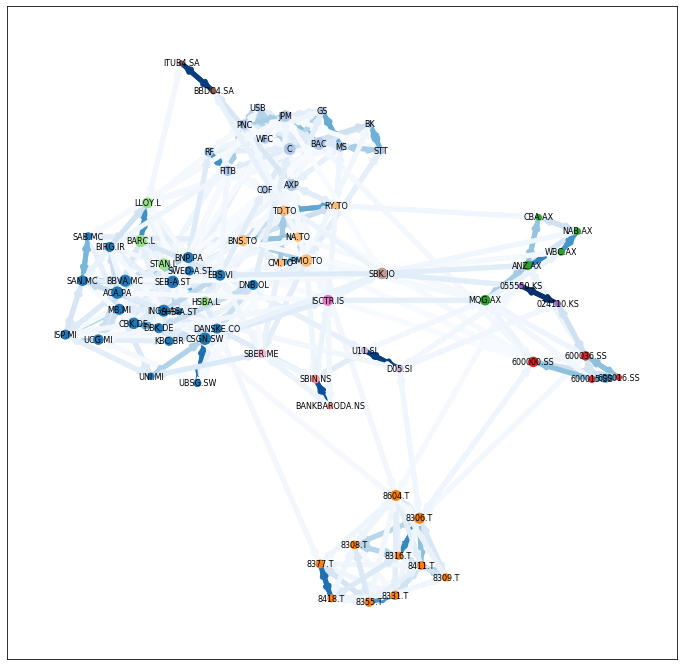

Date: 2020-06-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-06-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

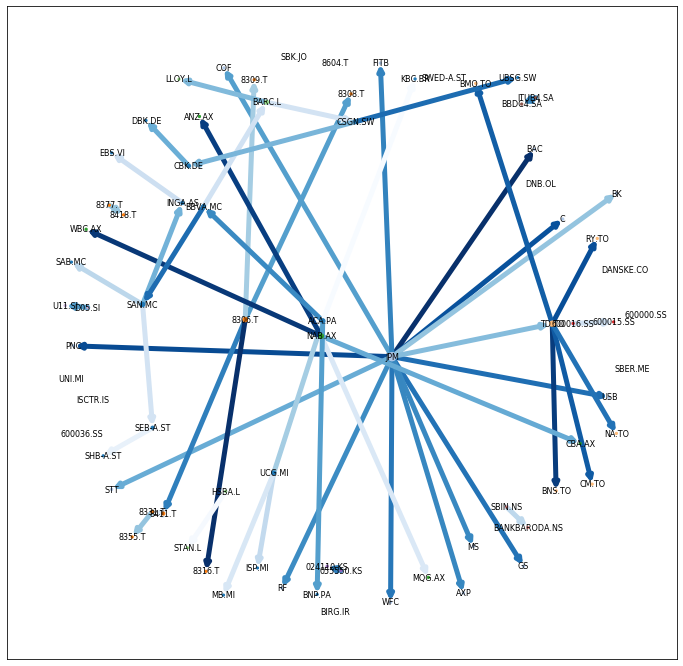

Date: 2020-09-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-09-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-09-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

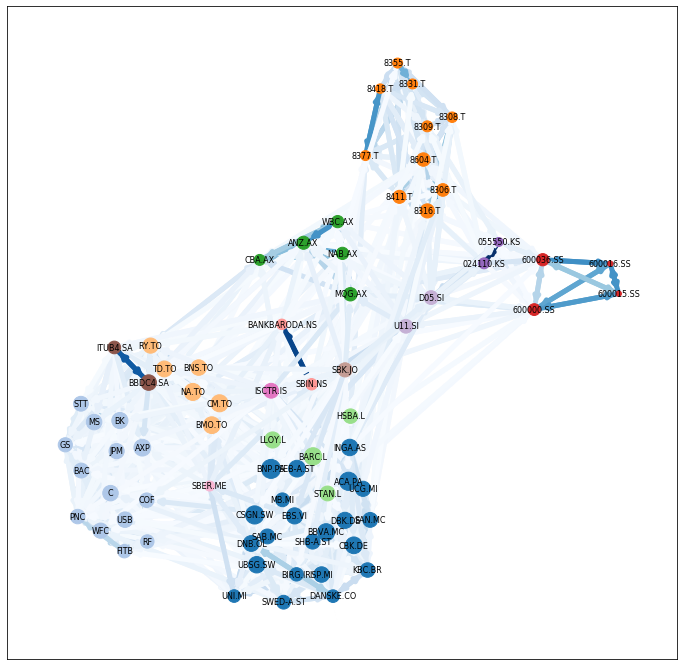

Date: 2020-09-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

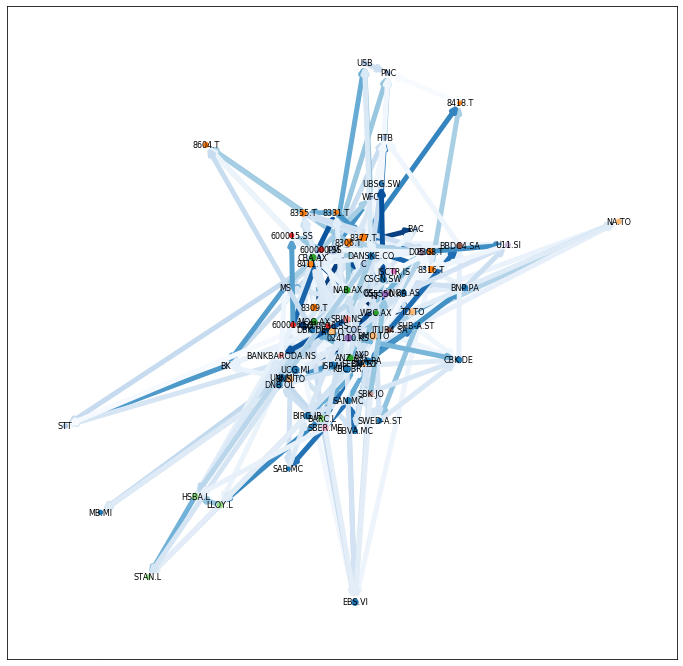

Date: 2020-12-23
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-12-23
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

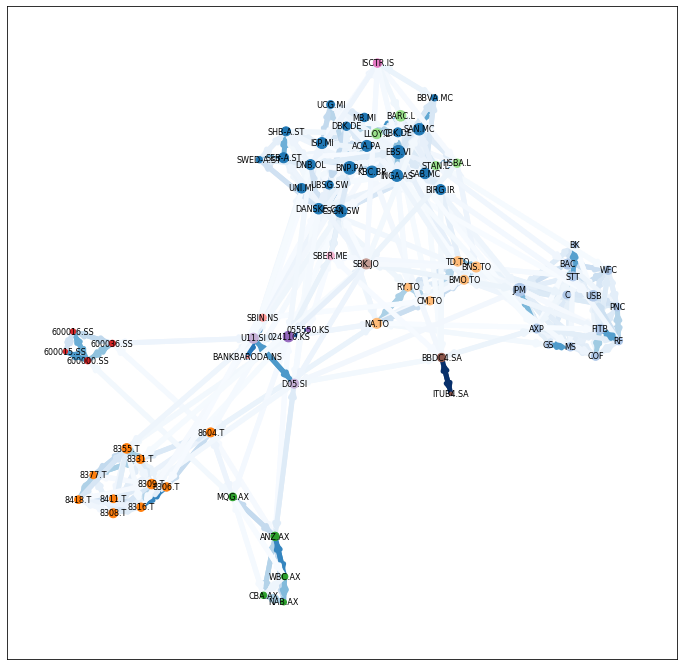

Date: 2020-12-23
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

Date: 2020-12-23
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

In [45]:
# Parameters
ts_type = "return"

# Iterables
dates = ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-23"]
methods = ['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']

for date in dates:

    for method in methods:
        
        print("Date: {}".format(date))

        network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

# Support

In [45]:
label_dict = {}

for i in range(0,len(var_names)):
    label_dict[i] = var_names[i]
    
# Relabel network
G = nx.relabel_nodes(G, label_dict)

In [46]:
# Get edge weights
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

In [47]:
# Customize ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.2, #1.0,

                        # Log
                        verbose=True)

In [48]:
# Parameters
plt.rcParams['figure.figsize'] = (12,12)

# Get degrees
degree_demirer = dict(G.degree)

#node_pos = forceatlas2.forceatlas2_networkx_layout(G, niter=1000)
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2476.97it/s]

BarnesHut Approximation  took  0.21  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


In [49]:
# Draw network
nx.draw_networkx(G,node_pos,
                     #nodelist=degree_mcc_network.keys(),
                     node_size=[v * 8 for v in degree_demirer.values()],
                     #node_color=colors,
                     font_size=8, node_color='grey',
                 edgelist=edges,
                 edge_color=weights,
                 width=5.0, edge_cmap=plt.cm.Blues,
                     with_labels=True)

plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

In [52]:
# equivalently
GI = igraph.Graph.TupleList(G.edges(), directed=False)
layout = forceatlas2.forceatlas2_igraph_layout(GI, pos=None, iterations=2000)
igraph.plot(GI).show()

100%|██████████| 2000/2000 [00:00<00:00, 3438.58it/s]


BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.26  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

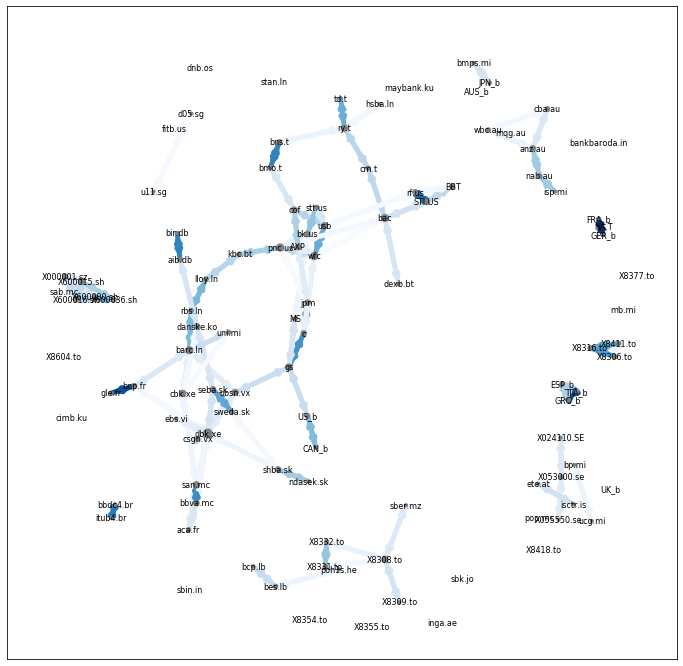

Method: DY_Lasso


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

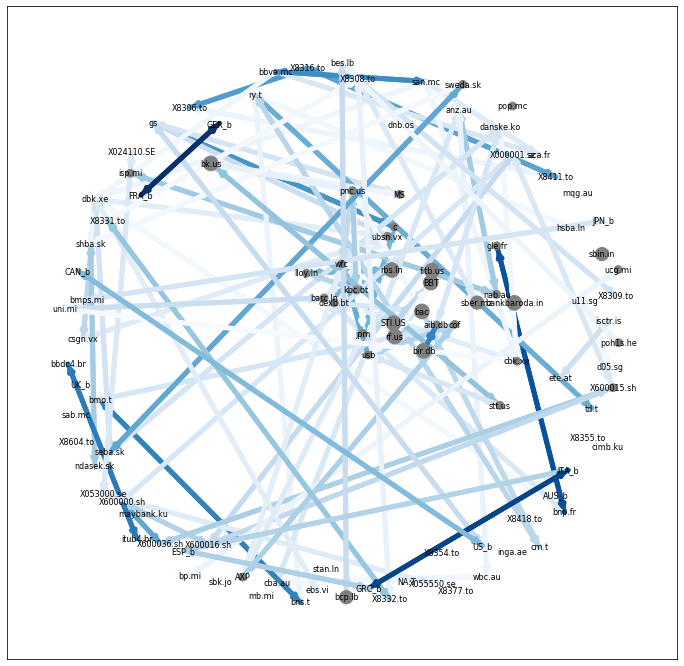

In [53]:
# Iterable (Methods to check)
methods = ["NS","DY_Lasso"]

# Other parameters
date = "2008-09-15"
ts_type = "volatility"

for method in methods:
    
    print("Method: {}".format(method))
    
    # Import network
    G = network_preprocessing(date,method,ts_type)
    
    label_dict = {}

    for i in range(0,len(var_names)):
        label_dict[i] = var_names[i]

    # Relabel network
    G = nx.relabel_nodes(G, label_dict)
    
    
    # Parameters
    plt.rcParams['figure.figsize'] = (12,12)

    # Get degrees
    degree_demirer = dict(G.degree)

    # Draw network
    nx.draw_networkx(G,
                         #nodelist=degree_mcc_network.keys(),
                         node_size=[v * 5 for v in degree_demirer.values()],
                         #node_color=colors,
                         font_size=8, node_color='grey',
                     edgelist=edges,
                     edge_color=weights,
                     width=5.0, edge_cmap=plt.cm.Blues,
                         with_labels=True)

    plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)
    plt.show()

In [44]:
# # Really naive example
# nx.draw(G, pos=nx.spring_layout(G))